<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus el libro la metamorfosis, de Kafka. El archivo se encuentra en el repositorio bajo en nombre la_metamorfosis.txt

In [37]:
#Separoel dataset tomando los puntos como separadores de oraciones y normalizo el texto eliminando acentos, convirtiendo a minúsculas y eliminando caracteres especiales
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remover acentos
    text = remove_accents(text)
    # Mantener letras, dígitos, espacios y puntos (para separar oraciones)
    text = re.sub(r'[^a-z0-9\s\.]', '', text)
    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

with open('la_metamorfosis.txt', encoding='utf-8') as f:
    raw_text = f.read().replace("\n", " ")

normalized_text = normalize_text(raw_text)
sentences = normalized_text.split('.')
df = pd.DataFrame(sentences, columns=[0])
df.head()

,0
0,cuando gregorio samsa se desperto una manana d...
1,estaba tumbado sobre su espalda dura y en for...
2,sus muchas patas ridiculamente pequenas en co...
3,que me ha ocurrido penso
4,no era un sueno


Consideraremos que cada secuencia para este dataset es una oración y cada palabra un token. 

Para buscar el largo maximo del contexto (cantidad de tokens) que puede consumir el modelo se analizará la cantidad de terminos preesentes por cada oración.



In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 652


### Elegir el tamaño del contexto

In [4]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [5]:
# cada oración la guardamos en una lista
text = list(df.loc[:,0])
text

['cuando gregorio samsa se desperto una manana despues de un sueno intranquilo se encontro sobre su cama convertido en un monstruoso insecto',
 ' estaba tumbado sobre su espalda dura y en forma de caparazon y al levantar un poco la cabeza veia un vientre abombado parduzco dividido por partes duras en forma de arco sobre cuya protuberancia apenas podia mantenerse el cobertor a punto ya de resbalar al suelo',
 ' sus muchas patas ridiculamente pequenas en comparacion con el resto de su tamano le vibraban desamparadas ante los ojos',
 ' que me ha ocurrido penso',
 ' no era un sueno',
 ' su habitacion una autentica habitacion humana si bien algo pequena permanecia tranquila entre las cuatro paredes harto conocidas',
 ' por encima de la mesa sobre la que se encontraba extendido un muestrario de panos desempaquetados samsa era viajante de comercio estaba colgado aquel cuadro que hacia poco habia recortado de una revista y habia colocado en un bonito marco dorado',
 ' representaba a una dama a

In [6]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [7]:
text[0]

'cuando gregorio samsa se desperto una manana despues de un sueno intranquilo se encontro sobre su cama convertido en un monstruoso insecto'

In [8]:
segmented_sentences[0]

['cuando',
 'gregorio',
 'samsa',
 'se',
 'desperto',
 'una',
 'manana',
 'despues',
 'de',
 'un',
 'sueno',
 'intranquilo',
 'se',
 'encontro',
 'sobre',
 'su',
 'cama',
 'convertido',
 'en',
 'un',
 'monstruoso',
 'insecto']

In [9]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 81., 121., 156., 101.,  70.,  32.,  40.,  25.,   6.,   2.,   5.,
          3.,   3.,   2.,   2.,   0.,   0.,   1.,   1.,   1.]),
 array([  0. ,   9.5,  19. ,  28.5,  38. ,  47.5,  57. ,  66.5,  76. ,
         85.5,  95. , 104.5, 114. , 123.5, 133. , 142.5, 152. , 161.5,
        171. , 180.5, 190. ]),
 <BarContainer object of 20 artists>)

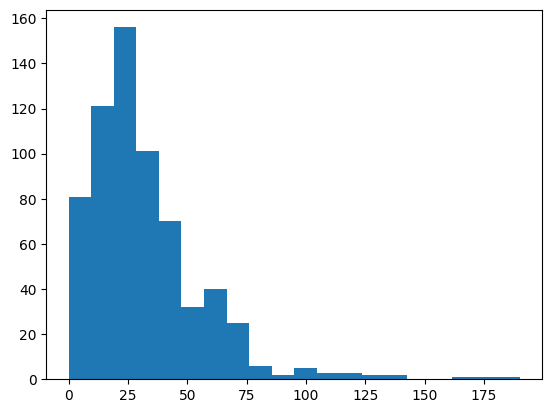

In [10]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [11]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 50)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 26


###  Tokenizar

In [12]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [13]:
tokenized_sentences[0]

[43,
 12,
 66,
 8,
 524,
 17,
 109,
 58,
 2,
 14,
 327,
 1434,
 8,
 525,
 41,
 11,
 69,
 526,
 6,
 14,
 1435,
 1436]

In [14]:
segmented_sentences[0]

['cuando',
 'gregorio',
 'samsa',
 'se',
 'desperto',
 'una',
 'manana',
 'despues',
 'de',
 'un',
 'sueno',
 'intranquilo',
 'se',
 'encontro',
 'sobre',
 'su',
 'cama',
 'convertido',
 'en',
 'un',
 'monstruoso',
 'insecto']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [15]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [16]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [17]:
len(tok_sent)

6491

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [18]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [19]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [20]:
train_seqs.shape

(165626, 27)

In [21]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [22]:
y.shape

(165626, 26)

In [23]:
# Palabras del vocabulario
tok.index_word

{1: 'la',
 2: 'de',
 3: 'que',
 4: 'y',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'se',
 9: 'con',
 10: 'no',
 11: 'su',
 12: 'gregorio',
 13: 'por',
 14: 'un',
 15: 'habia',
 16: 'los',
 17: 'una',
 18: 'las',
 19: 'pero',
 20: 'como',
 21: 'lo',
 22: 'al',
 23: 'si',
 24: 'ya',
 25: 'del',
 26: 'mas',
 27: 'para',
 28: 'le',
 29: 'hacia',
 30: 'hermana',
 31: 'habitacion',
 32: 'padre',
 33: 'todo',
 34: 'madre',
 35: 'sus',
 36: 'estaba',
 37: 'puerta',
 38: 'sin',
 39: 'era',
 40: 'tenia',
 41: 'sobre',
 42: 'porque',
 43: 'cuando',
 44: 'podia',
 45: 'solo',
 46: 'esta',
 47: 'ahora',
 48: 'vez',
 49: 'es',
 50: 'tiempo',
 51: 'ella',
 52: 'apoderado',
 53: 'senor',
 54: 'dijo',
 55: 'otra',
 56: 'hubiese',
 57: 'este',
 58: 'despues',
 59: 'poco',
 60: 'cabeza',
 61: 'mismo',
 62: 'desde',
 63: 'habian',
 64: 'muy',
 65: 'momento',
 66: 'samsa',
 67: 'ni',
 68: 'familia',
 69: 'cama',
 70: 'forma',
 71: 'incluso',
 72: 'asi',
 73: 'bien',
 74: 'alli',
 75: 'entonces',
 76: 'antes',
 77: '

In [24]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3463

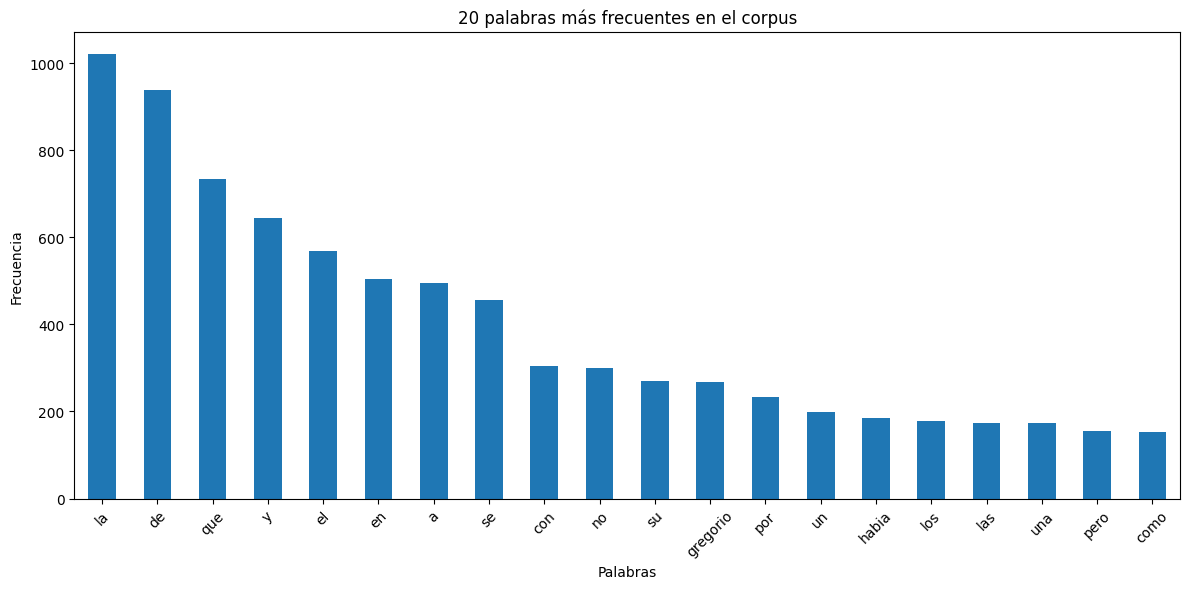

Total de palabras únicas: 3463
Palabra más frecuente: 'la' con 1021 apariciones
Promedio de apariciones por palabra: 6.01


In [25]:
# Crear un gráfico de las palabras más frecuentes
word_freq = pd.Series(tok.word_counts).sort_values(ascending=False)

# Mostrar las 20 palabras más frecuentes
plt.figure(figsize=(12, 6))
word_freq.head(20).plot(kind='bar')
plt.title('20 palabras más frecuentes en el corpus')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# También mostrar estadísticas
print(f"Total de palabras únicas: {len(word_freq)}")
print(f"Palabra más frecuente: '{word_freq.index[0]}' con {word_freq.iloc[0]} apariciones")
print(f"Promedio de apariciones por palabra: {word_freq.mean():.2f}")

In [26]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'desperto': 4, 'un': 158, 'una': 145, 'convertido': 4, 'monstruoso': 1, 'se': 319, 'manana': 22, 'su': 195, 'sobre': 64, 'cuando': 60, 'samsa': 29, 'cama': 27, 'despues': 34, 'en': 302, 'gregorio': 221, 'sueno': 7, 'encontro': 4, 'de': 415, 'insecto': 1, 'intranquilo': 1, 'mantenerse': 1, 'al': 119, 'vientre': 5, 'podia': 52, 'cobertor': 2, 'a': 303, 'partes': 8, 'forma': 29, 'resbalar': 1, 'ya': 123, 'suelo': 24, 'parduzco': 2, 'espalda': 17, 'la': 427, 'veia': 14, 'protuberancia': 1, 'por': 173, 'el': 358, 'poco': 33, 'arco': 3, 'cuya': 4, 'abombado': 1, 'duras': 1, 'cabeza': 35, 'levantar': 5, 'y': 386, 'tumbado': 12, 'dividido': 1, 'apenas': 17, 'dura': 2, 'punto': 7, 'estaba': 75, 'caparazon': 2, 'desamparadas': 1, 'pequenas': 3, 'los': 140, 'muchas': 7, 'ante': 20, 'ojos': 21, 'resto': 5, 'tamano': 2, 'comparacion': 1, 'vibraban': 1, 'patas': 4, 'ridiculamente': 1, 'le': 96, 'sus': 81, 'con': 225, 'que': 375, 'penso': 9, 'me': 23, 'ha': 16, 'ocurrido':


### Definir el modelo

Usaremos un embedding preentrenado dado que para entrenar un embedding y obtener buenos resultados se suele requerir una gran cantidad de datos y el corpues que tenemos y capacidad de computo son bajos.

In [30]:
import os
import urllib.request
import gzip
import shutil

# Nombre del archivo final y URL oficial de FastText
model_path = "cc.es.300.bin"
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz"

# Descargar solo si no existe
if not os.path.exists(model_path):
    print("Descargando modelo FastText en español...")
    gz_path = model_path + ".gz"
    urllib.request.urlretrieve(url, gz_path)
    print("Descompresión...")
    with gzip.open(gz_path, 'rb') as f_in:
        with open(model_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(gz_path)  # Eliminar el .gz para ahorrar espacio
    print("Modelo descargado y listo.")
else:
    print("Modelo ya presente, no se descarga.")

# Cargar el modelo
from gensim.models.fasttext import load_facebook_model
ft = load_facebook_model(model_path)
print("Dimensión de embedding:", ft.vector_size)

Descargando modelo FastText en español...
Descompresión...
Modelo descargado y listo.
Dimensión de embedding: 300


In [ ]:
def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remover acentos
    text = remove_accents(text)
    # Mantener letras, dígitos, espacios y puntos (para separar oraciones)
    text = re.sub(r'[^a-z0-9\s\.]', '', text)
    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
embedding_dim = ft.vector_size
embedding_matrix = np.zeros((vocab_size+1, embedding_dim), dtype='float32')
#normalizamos las palabras del vocabulario y las buscamos en el modelo de FastText
# si la palabra no está en el modelo, se deja el vector de embedding en 0
for wor, idx in tok.word_index.items():
    if idx < vocab_size+1: 
        try:
            embedding_matrix[idx] = ft.get_vector(normalize_text(wor))
        except:
            pass


In [39]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, weights = [embedding_matrix], trainable = False, mask_zero = True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,039,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,039,200 (3.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,039,200 (3.96 MB)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [42]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [46]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
2587/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.0162
 mean perplexity: 1029.5950247745968 

Saved new model!
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 97s 38ms/step - loss: 5.9923
Epoch 2/20
2587/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.9813
 mean perplexity: 1027.6464463447899 

Saved new model!
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 97s 38ms/step - loss: 5.9790
Epoch 3/20
2587/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.9775
 mean perplexity: 1021.8770410605763 

Saved new model!
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 98s 38ms/step - loss: 5.9782
Epoch 4/20
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.9761
 mean perplexity: 1043.45305753883 

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 93s 36ms/step - loss: 5.9776
Epoch 5/20
2587/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.9755
 mean perplexity: 1024.9145860342603 

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - loss: 5.9769
Epoch 6/20
2587/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.9761
 mean perplexity: 1019.8136137338981

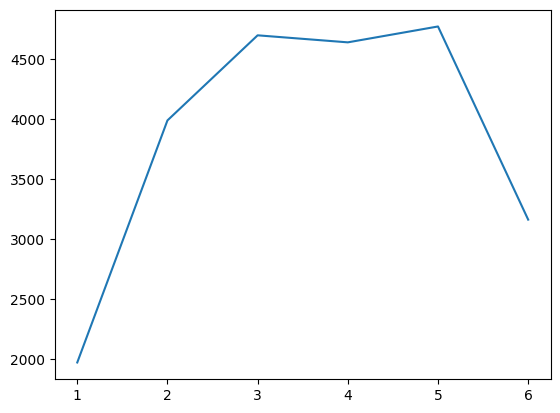

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [161]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra

In [135]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [162]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text
  
  
input_text='cuando gregorio samsa se desperto una'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

In [164]:
input_text='cuando gregorio samsa se desperto una'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'cuando gregorio samsa se desperto una de la de la de la de la de la'

Puede evrse que agrega stopwords mayoritariamente. Esto tiene sentido considerando que este metodo pone la palabra ams probable y las stop words eran las que ams predominancia tenian por bastanet diferencia en el texto.

###  Beam search y muestreo aleatorio

In [139]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [140]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [141]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Cuando Gregorio Samsa se desperto una",temp=1,mode='sto')

In [142]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 32)

In [143]:
# veamos las salidas
decode(salidas[0])

['cuando gregorio samsa se desperto una habitacion de la puerta para que']

Puede verse que al probar beam search estocastico, la aparicion de stop words disminuye y aparecen palabras con mas significado. Sin embargo, la frase no tiene mucho sentido, lo que demuestra que el modelo no es muy eficiente para la prediccion de texto.